<h2>Housing Recommender model

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

In [2]:
df1 = pd.read_csv("ph_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Bacoor,1 BHK,Coomee,284,1.0,1.0,552000
1,Plot Area,Immediate Possession,Cotabato City,NaN,Theanmp,1350,NaN,NaN,582360
2,Built-up Area,Ready To Move,San Juan,1 BHK,NaN,450,1.0,1.0,621000
3,Built-up Area,18-Mar,Talisay,1 BHK,Soiewre,340,1.0,1.0,690000
4,Super built-up Area,18-Jan,Sipalay,3 BHK,NaN,167Sq. Meter,3.0,2.0,690000


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [7]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

**Drop features that are not required to build our model**

In [8]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

In [9]:
df2.head()

,location,size,total_sqft,bath,price
0,Bacoor,1 BHK,284,1.0,552000
1,Cotabato City,NaN,1350,NaN,582360
2,San Juan,1 BHK,450,1.0,621000
3,Talisay,1 BHK,340,1.0,690000
4,Sipalay,3 BHK,167Sq. Meter,3.0,690000


<h2 style='color:blue'>Handle NA values</h2>

In [10]:
df2.isnull().sum()

location       0
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [11]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [12]:
df3.shape

(13247, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [13]:
df3['size'].unique()

array(['1 BHK', '3 BHK', '2 Bedroom', '2 BHK', '1 Bedroom', '1 RK',
       '4 Bedroom', '3 Bedroom', '4 BHK', '5 Bedroom', '8 Bedroom',
       '7 Bedroom', '6 Bedroom', '5 BHK', '7 BHK', '6 BHK', '9 Bedroom',
       '10 Bedroom', '8 BHK', '14 BHK', '9 BHK', '11 Bedroom', '11 BHK',
       '10 BHK', '18 Bedroom', '27 BHK', '13 BHK', '12 Bedroom', '19 BHK',
       '16 BHK', '43 Bedroom'], dtype=object)

In [14]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

array([ 1,  3,  2,  4,  5,  8,  7,  6,  9, 10, 14, 11, 18, 27, 13, 12, 19,
       16, 43], dtype=int64)

In [15]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Bacoor,1 BHK,284,1.0,552000,1
2,San Juan,1 BHK,450,1.0,621000,1
3,Talisay,1 BHK,340,1.0,690000,1
4,Sipalay,3 BHK,167Sq. Meter,3.0,690000,3
5,Santiago,1 BHK,400,1.0,690000,1


**Explore total_sqft feature**

In [16]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [17]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
4,Sipalay,3 BHK,167Sq. Meter,3.0,690000,3
29,Toledo,1 BHK,540 - 565,1.0,914940,1
65,Lapu-Lapu,1 BHK,520 - 645,1.0,1044315,1
114,Vigan,1 BHK,633 - 666,1.0,1209915,1
115,Roxas,1 BHK,580 - 650,1.0,1230615,1
124,Ozamiz,1 BHK,45.06Sq. Meter,2.0,1242000,1
129,Talisay,1 BHK,650 - 665,1.0,1270290,1
131,Maasin,1 BHK,34.46Sq. Meter,1.0,1276500,1
141,Bacoor,2 BHK,770 - 841,2.0,1333770,2
153,Muntinlupa,1 BHK,381 - 535,1.0,1358955,1


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion.**

In [18]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [19]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Bacoor,1 BHK,284.0,1.0,552000,1
2,San Juan,1 BHK,450.0,1.0,621000,1


In [20]:
df4.loc[30]

location      Baybay
size           1 BHK
total_sqft     605.0
bath             1.0
price         918390
bhk                1
Name: 30, dtype: object

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [21]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Bacoor,1 BHK,284.0,1.0,552000,1,1943.661972
2,San Juan,1 BHK,450.0,1.0,621000,1,1380.000000
3,Talisay,1 BHK,340.0,1.0,690000,1,2029.411765
5,Santiago,1 BHK,400.0,1.0,690000,1,1725.000000
6,Carcar,1 BHK,470.0,2.0,690000,1,1468.085106


In [22]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320100e+04
mean     5.465191e+03
std      7.363895e+04
min      1.848026e+02
25%      2.944770e+03
50%      3.752266e+03
75%      5.048780e+03
max      8.280000e+06
Name: price_per_sqft, dtype: float64

In [23]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [24]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Talisay         189
San Carlos      187
San Fernando    186
Naga            184
Malaybalay       95
               ... 
El Salvador      91
Maasin           91
Tagum            91
Tacurong         91
Dumaguete        91
Name: location, Length: 137, dtype: int64

In [25]:
location_stats.values.sum()

13201

In [26]:
len(location_stats[location_stats>10])

137

In [27]:
len(location_stats)

137

In [28]:
len(location_stats[location_stats<=10])

0

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [29]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Series([], Name: location, dtype: int64)

In [30]:
len(df5.location.unique())

137

In [31]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

137

In [32]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Bacoor,1 BHK,284.0,1.0,552000,1,1943.661972
2,San Juan,1 BHK,450.0,1.0,621000,1,1380.000000
3,Talisay,1 BHK,340.0,1.0,690000,1,2029.411765
5,Santiago,1 BHK,400.0,1.0,690000,1,1725.000000
6,Carcar,1 BHK,470.0,2.0,690000,1,1468.085106
7,Quezon City,1 BHK,410.0,1.0,690000,1,1682.926829
8,Canlaon,1 BHK,410.0,1.0,690000,1,1682.926829
9,Dapitan,1 BHK,395.0,1.0,707250,1,1790.506329
10,Santo Tomas,1 BHK,400.0,1.0,707250,1,1768.125000
11,Dipolog,2 Bedroom,640.0,1.0,724500,2,1132.031250


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

Normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum threshold per bhk to be 300 sqft

In [33]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Bacoor,1 BHK,284.0,1.0,552000,1,1943.661972
49,Laoag,2 BHK,460.0,1.0,1035000,2,2250.000000
51,Victorias,2 BHK,550.0,1.0,1035000,2,1881.818182
52,Tabaco,2 BHK,550.0,1.0,1035000,2,1881.818182
57,Escalante,2 BHK,550.0,1.0,1035000,2,1881.818182


In [34]:
df5.shape

(13201, 7)

In [35]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12457, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [36]:
df6.price_per_sqft.describe()

count     12457.000000
mean       4352.815243
std        2875.898205
min         184.802571
25%        2905.263158
50%        3652.941176
75%        4772.500000
max      121764.705882
Name: price_per_sqft, dtype: float64

This shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [37]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10894, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

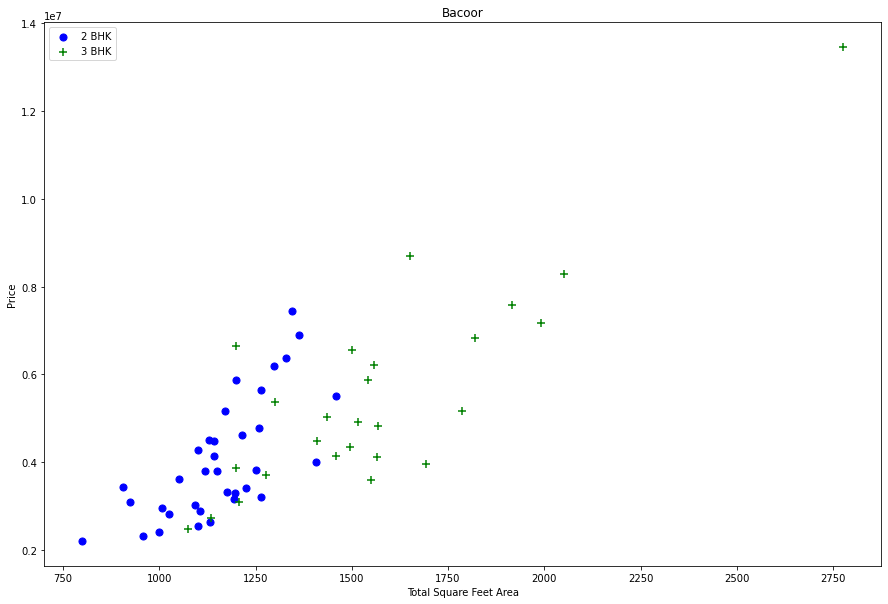

In [38]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Bacoor")

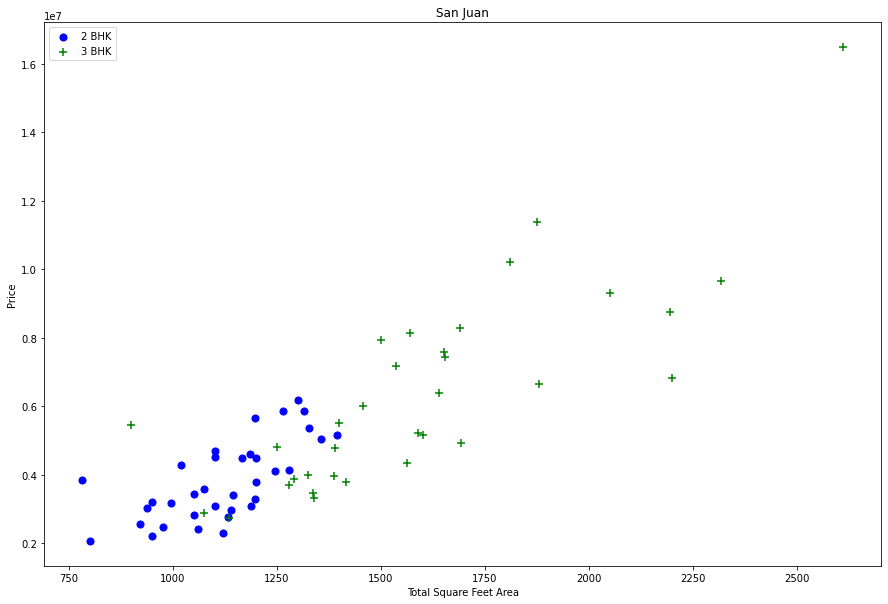

In [39]:
plot_scatter_chart(df7,"San Juan")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [40]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(8364, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

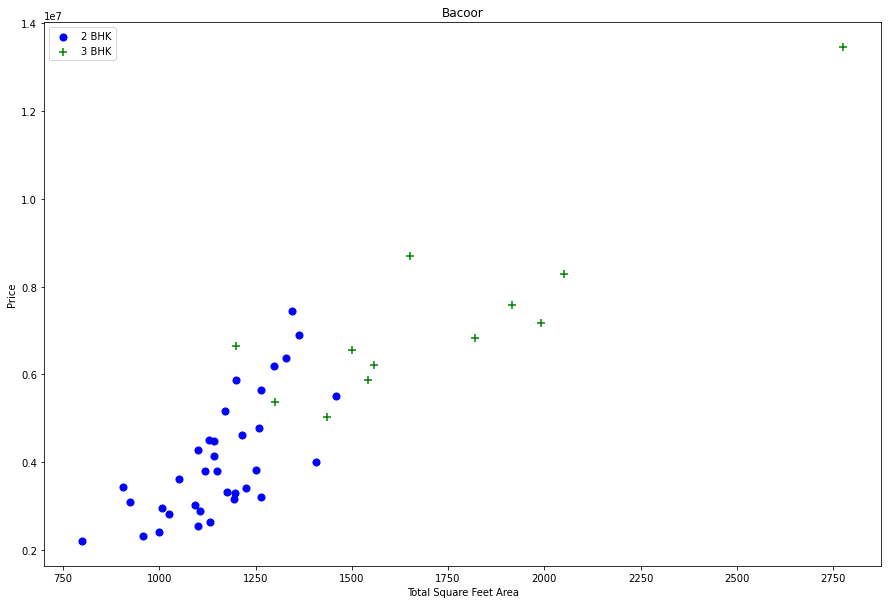

In [41]:
plot_scatter_chart(df8,"Bacoor")

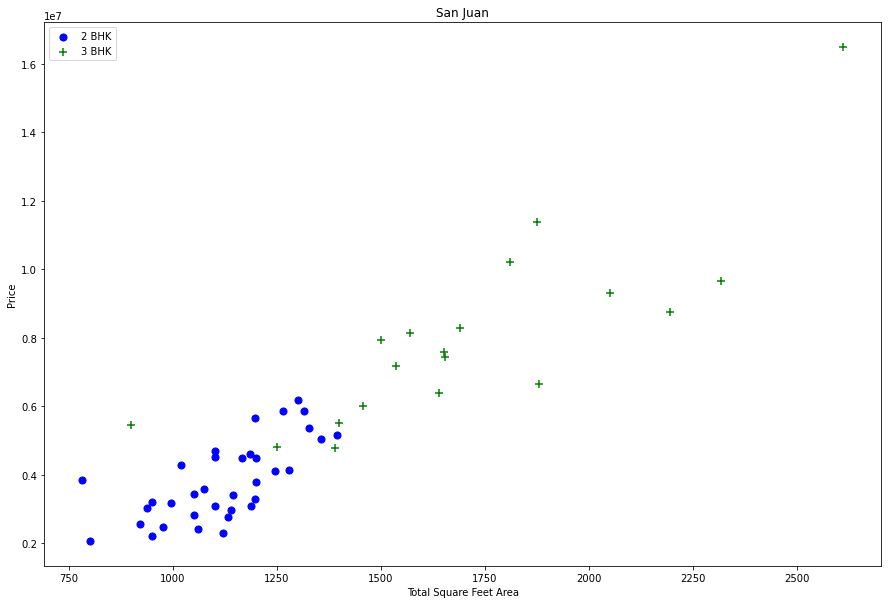

In [42]:
plot_scatter_chart(df8,"San Juan")

Text(0, 0.5, 'Count')

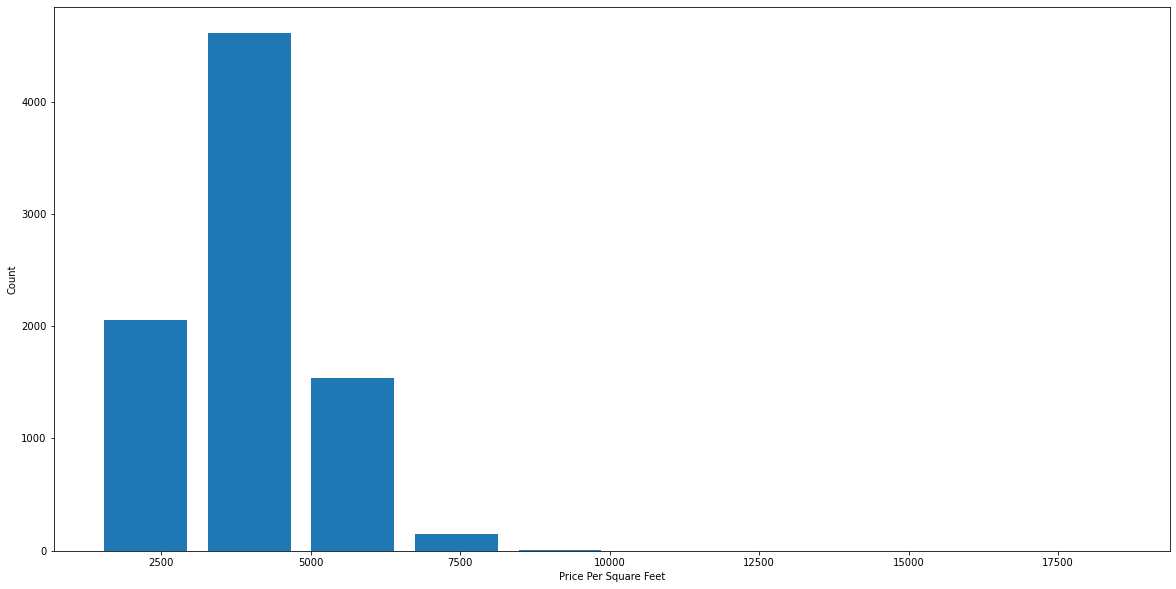

In [43]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [44]:
df8.bath.unique()

array([ 1.,  2.,  3.,  4.,  6.,  5.,  9.,  8.,  7., 12., 16., 10., 13.])

Text(0, 0.5, 'Count')

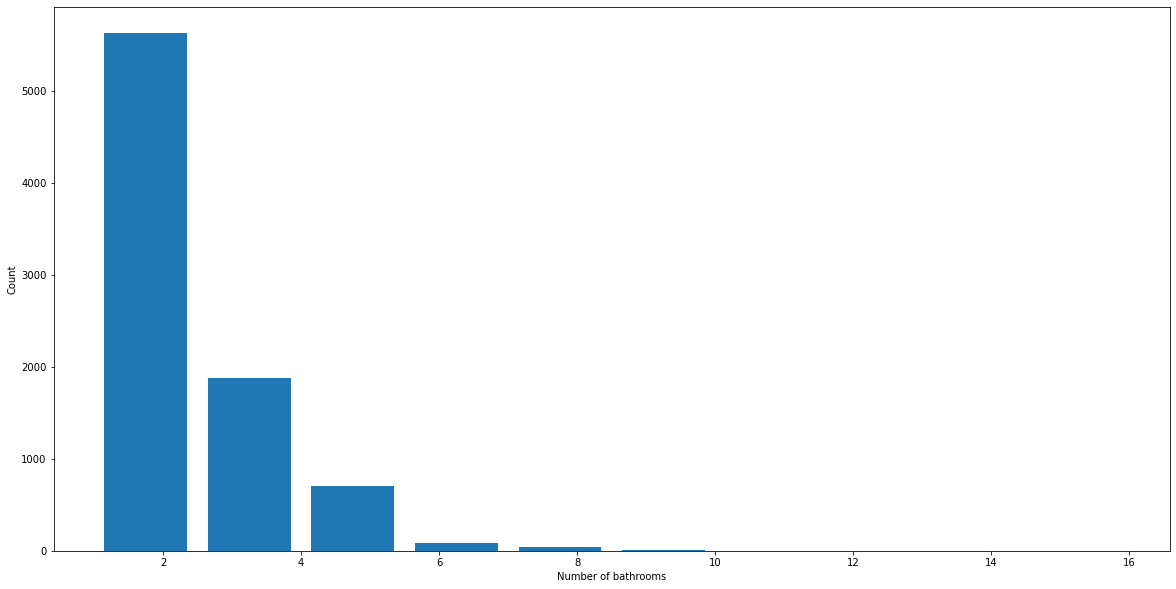

In [45]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [46]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
3249,Dumaguete,10 BHK,12000.0,12.0,36225000,10,3018.750000
5109,Lipa,16 BHK,10000.0,16.0,37950000,16,3795.000000
6951,Pagadian,13 BHK,5425.0,13.0,18975000,13,3497.695853
10041,Tanjay,10 BHK,4000.0,12.0,11040000,10,2760.000000


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [47]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5174,Lucena,3 BHK,1806.0,6.0,8004000,3,4431.893688
5325,Mabalacat,4 Bedroom,7000.0,8.0,31050000,4,4435.714286


**If you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [48]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(8293, 7)

In [49]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Alaminos,1 BHK,740.0,1.0,1631850,1,2205.202703
1,Alaminos,1 BHK,710.0,1.0,1863000,1,2623.943662


In [50]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,Alaminos,740.0,1.0,1631850,1
1,Alaminos,710.0,1.0,1863000,1
3,Alaminos,565.0,1.0,2277000,1


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [51]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,Alaminos,Angeles,Antipolo,Bacolod,Bacoor,Bago,Baguio,Bais,Balanga,Batac,...,Tayabas,Toledo,Trece Martires,Tuguegarao,Urdaneta,Valencia,Valenzuela,Victorias,Vigan,Zamboanga City
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df11 = pd.concat([df10,dummies],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,Alaminos,Angeles,Antipolo,Bacolod,Bacoor,...,Tayabas,Toledo,Trece Martires,Tuguegarao,Urdaneta,Valencia,Valenzuela,Victorias,Vigan,Zamboanga City
0,Alaminos,740.0,1.0,1631850,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alaminos,710.0,1.0,1863000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alaminos,565.0,1.0,2277000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Alaminos,784.0,1.0,2434665,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Alaminos,720.0,2.0,3105000,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,Alaminos,Angeles,Antipolo,Bacolod,Bacoor,Bago,...,Tayabas,Toledo,Trece Martires,Tuguegarao,Urdaneta,Valencia,Valenzuela,Victorias,Vigan,Zamboanga City
0,740.0,1.0,1631850,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,710.0,1.0,1863000,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2 style='color:blue'>Build a Model Now...</h2>

In [54]:
df12.shape

(8293, 141)

In [55]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,Alaminos,Angeles,Antipolo,Bacolod,Bacoor,Bago,Baguio,...,Tayabas,Toledo,Trece Martires,Tuguegarao,Urdaneta,Valencia,Valenzuela,Victorias,Vigan,Zamboanga City
0,740.0,1.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,710.0,1.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,565.0,1.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
X.shape

(8293, 140)

In [57]:
y = df12.price
y.head(3)

0    1631850
1    1863000
3    2277000
Name: price, dtype: int64

In [58]:
len(y)

8293

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [60]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8863810189682368

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [61]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.88716775, 0.80669104, 0.79492189, 0.82527956, 0.84929423])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [62]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor


def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'normalize': [True, False],
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [-(2^3)],
                'fit_intercept': [True],
                'selection': ['cyclic'],
                'normalize' : [True]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.832671,"{'fit_intercept': True, 'normalize': False, 'p..."
1,lasso,0.832668,"{'alpha': -1, 'fit_intercept': True, 'normaliz..."
2,decision_tree,0.795111,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style='color:blue'>Test the model for few properties</h2>

In [63]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [64]:
predict_price('Quezon City',1000, 2, 2)

3901762.125

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [65]:
import pickle
with open('ph_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [66]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))